In [1]:
import os
import cv2
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from scipy.spatial.distance import cdist

In [2]:
PROJECT_DIR = "flowers_example"
SFM_PATH = f"../{PROJECT_DIR}"
OBJECTIVE_POINTS = ([0.1, 0.2, 0.6], [0, -0.4, 1.2])

# 1. Split the video into frames

In [3]:
def split_video_into_frames():
    output_folder = os.path.join(f"{SFM_PATH}/images")
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    cap = cv2.VideoCapture(f"{SFM_PATH}/video.mp4")
    
    frame_count = 0
    
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        frame_path = os.path.join(output_folder, f"frame_{frame_count:04d}.jpg")
        cv2.imwrite(frame_path, frame)
        
        frame_count += 1
    
    cap.release()

split_video_into_frames()

# 2. SfM

In [4]:
def start_sfm():
    commands = [f".\COLMAP.bat automatic_reconstructor --image_path {PROJECT_DIR}/images --workspace_path {PROJECT_DIR}",
                f".\COLMAP.bat model_converter --input_path {PROJECT_DIR}/sparse/0 --output_path {PROJECT_DIR} --output_type TXT"]

    for command in commands:
        try:
            process = subprocess.Popen(command, cwd="..", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            stdout, stderr = process.communicate()

            if process.returncode == 0:
                print("Command executed successfully:")
                print(stdout.decode())
            else:
                print("Error occurred during command execution:")
                print(stderr.decode())
        except Exception as e:
            print("Error:", str(e))


start_sfm()

Command executed successfully:
iter      cost      cost_change  |gradient|   |step|    tr_ratio  tr_radius  ls_iter  iter_time  total_time
   0  6.319496e+01    0.00e+00    1.07e+04   0.00e+00   0.00e+00  1.00e+04        0    2.72e-04    7.70e-04
   1  4.341843e+01    1.98e+01    4.50e+02   1.19e+01   1.00e+00  3.00e+04        1    6.14e-04    1.41e-03
   2  4.329406e+01    1.24e-01    8.10e+01   1.75e+01   1.01e+00  9.00e+04        1    3.80e-04    1.81e-03
   3  4.339062e+01   -9.66e-02    8.10e+01   3.88e+01  -9.39e-01  4.50e+04        1    1.74e-04    2.00e-03
   4  4.324996e+01    4.41e-02    1.68e+02   2.08e+01   7.55e-01  5.19e+04        1    3.53e-04    2.36e-03
   5  4.320155e+01    4.84e-02    2.32e+02   2.18e+01   6.85e-01  5.46e+04        1    4.08e-04    2.78e-03
   6  4.314816e+01    5.34e-02    2.28e+02   2.11e+01   7.15e-01  5.94e+04        1    3.78e-04    3.17e-03
   7  4.309932e+01    4.88e-02    2.26e+02   2.08e+01   6.95e-01  6.31e+04        1    3.89e-04    3.57e-

# 3. Load the image data and calculate camera poses

In [5]:
with open(os.path.join(SFM_PATH, 'images.txt'), 'r') as file:
    lines = file.readlines()

data = {
    'IMAGE_ID': [],
    'QW': [],
    'QX': [],
    'QY': [],
    'QZ': [],
    'TX': [],
    'TY': [],
    'TZ': [],
    'CAMERA_ID': [],
    'NAME': []
}

for line in lines:
    if "jpg" in line:
        line_data = line.strip().split(' ')
        image_id, qw, qx, qy, qz, tx, ty, tz, camera_id, name = line_data
        data['IMAGE_ID'].append(image_id)
        data['QW'].append(qw)
        data['QX'].append(qx)
        data['QY'].append(qy)
        data['QZ'].append(qz)
        data['TX'].append(tx)
        data['TY'].append(ty)
        data['TZ'].append(tz)
        data['CAMERA_ID'].append(camera_id)
        data['NAME'].append(name)

df = pd.DataFrame(data)

df.head()

,IMAGE_ID,QW,QX,QY,QZ,TX,TY,TZ,CAMERA_ID,NAME
0,1,0.99842686589876961,0.0095371706863940451,-0.053173946570981658,-0.015012236106771082,3.968949595059001,-1.1595379344778038,1.3191893281812967,3,frame_0002.jpg
1,2,0.99846132215340921,0.008736299860747667,-0.052896592890034247,-0.01416388679124784,3.9917668217830728,-1.129934035857076,1.3187901091403518,8,frame_0007.jpg
2,3,0.99844628440092331,0.0092998279019357762,-0.052974149454546211,-0.014569483743507109,3.9827919497254936,-1.1414087605267669,1.3157155361021997,5,frame_0004.jpg
3,4,0.99843357257747223,0.0094998100667645306,-0.053007514260846676,-0.015177555493796272,3.9386075703262771,-1.1815276388831049,1.3470728628260404,1,frame_0000.jpg
4,5,0.99842117158534216,0.0096708784106969564,-0.053202064814452631,-0.01520455656693567,3.9558805466784079,-1.1697372419977889,1.345303753973238,2,frame_0001.jpg


In [6]:
def quaternion_to_rotation_matrix(qw, qx, qy, qz):
    R = np.array([
        [1 - 2*qy**2 - 2*qz**2, 2*qx*qy - 2*qz*qw, 2*qx*qz + 2*qy*qw],
        [2*qx*qy + 2*qz*qw, 1 - 2*qx**2 - 2*qz**2, 2*qy*qz - 2*qx*qw],
        [2*qx*qz - 2*qy*qw, 2*qy*qz + 2*qx*qw, 1 - 2*qx**2 - 2*qy**2]
    ])

    return R

def add_camera_position_column(df):
    # camera position = -R^t * T
    rotation_matrices = np.array([quaternion_to_rotation_matrix(float(row['QW']), float(row['QX']), float(row['QY']), float(row['QZ'])) for _, row in df.iterrows()])
    inverse_rotation_matrices = np.transpose(rotation_matrices, axes=(0, 2, 1))
    translation_vectors = df[['TX', 'TY', 'TZ']].astype(float).values
    camera_positions = np.matmul(inverse_rotation_matrices, translation_vectors.reshape(-1, 3, 1)).squeeze()
    df['CAMERA_POSITION'] = [position.tolist() for position in camera_positions]


add_camera_position_column(df)

df.head()

,IMAGE_ID,QW,QX,QY,QZ,TX,TY,TZ,CAMERA_ID,NAME,CAMERA_POSITION
0,1,0.99842686589876961,0.0095371706863940451,-0.053173946570981658,-0.015012236106771082,3.968949595059001,-1.1595379344778038,1.3191893281812967,3,frame_0002.jpg,"[4.120346867341741, -1.0166225436532776, 0.909..."
1,2,0.99846132215340921,0.008736299860747667,-0.052896592890034247,-0.01416388679124784,3.9917668217830728,-1.129934035857076,1.3187901091403518,8,frame_0007.jpg,"[4.139808431279525, -0.9951103014899445, 0.906..."
2,3,0.99844628440092331,0.0092998279019357762,-0.052974149454546211,-0.014569483743507109,3.9827919497254936,-1.1414087605267669,1.3157155361021997,5,frame_0004.jpg,"[4.131904716983547, -1.0023120846299536, 0.905..."
3,4,0.99843357257747223,0.0094998100667645306,-0.053007514260846676,-0.015177555493796272,3.9386075703262771,-1.1815276388831049,1.3470728628260404,1,frame_0000.jpg,"[4.0938565966221985, -1.0376458126384769, 0.94..."
4,5,0.99842117158534216,0.0096708784106969564,-0.053202064814452631,-0.01520455656693567,3.9558805466784079,-1.1697372419977889,1.345303753973238,2,frame_0001.jpg,"[4.110900034667587, -1.0247874701492443, 0.936..."


# 4. Visualize cameras

In [7]:
fig = go.Figure(data=[go.Scatter3d(
    x=df['CAMERA_POSITION'].apply(lambda pos: pos[0]),
    y=df['CAMERA_POSITION'].apply(lambda pos: pos[1]),
    z=df['CAMERA_POSITION'].apply(lambda pos: pos[2]),
    mode='markers',
    marker=dict(
        size=5,
        color='red',
        opacity=0.8
    )
)])

fig.update_layout(
    scene=dict(
        xaxis_title='X',
        yaxis_title='Y',
        zaxis_title='Z',
        aspectmode='data'
    )
)

fig.update_layout(title_text='Camera Positions in 3D Space')

fig.show()

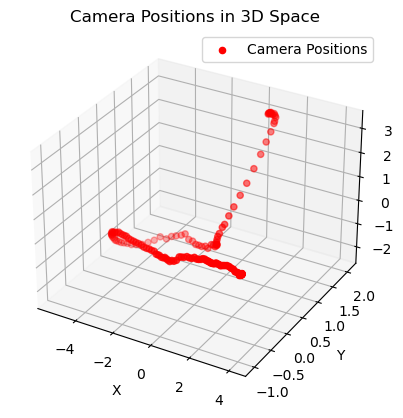

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

x = df['CAMERA_POSITION'].apply(lambda pos: pos[0])
y = df['CAMERA_POSITION'].apply(lambda pos: pos[1])
z = df['CAMERA_POSITION'].apply(lambda pos: pos[2])

ax.scatter(x, y, z, c='r', marker='o', label='Camera Positions')

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

plt.title('Camera Positions in 3D Space')

plt.legend()
plt.show()

# 5. Find nearest cameras/images to given points

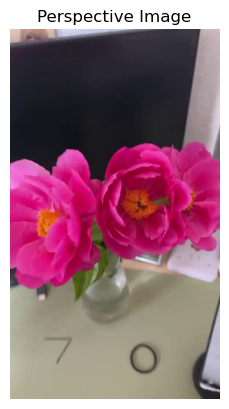

(IMAGE_ID                                                         130
QW                                               0.99692855512561807
QX                                              0.040664299390671871
QY                                              0.047064621456792535
QZ                                              0.047589832289494816
TX                                               0.70120192691231242
TY                                               0.66326438063392246
TZ                                               0.41051521302176597
CAMERA_ID                                                        130
NAME                                                  frame_0129.jpg
CAMERA_POSITION    [0.723459561955732, 0.6293383790013407, 0.4250...
Name: 129, dtype: object, array([0.77694362]))


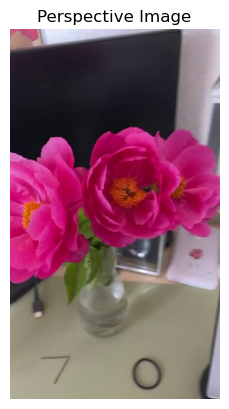

(IMAGE_ID                                                          52
QW                                                 0.998645827097564
QX                                           -6.5920277194276666e-05
QY                                              0.047544402228642556
QZ                                               0.02111959970881316
TX                                               0.33868974113784345
TY                                              -0.58427687238466697
TZ                                               0.12098759911903241
CAMERA_ID                                                         52
NAME                                                  frame_0051.jpg
CAMERA_POSITION    [0.30072477974822015, -0.5978173399085968, 0.1...
Name: 51, dtype: object, array([1.10870692]))


In [11]:
def find_nearest_camera(df, point):
    distances = cdist(df['CAMERA_POSITION'].tolist(), [point])
    nearest_index = distances.argmin()
    return (df.iloc[nearest_index], distances[nearest_index])

def get_nearest_images(df, show=True):
    for point in OBJECTIVE_POINTS:
        nearest_camera = find_nearest_camera(df, point)

        if show:
            perspective_image_name = nearest_camera[0].NAME
            perspective_image = plt.imread(f"{SFM_PATH}/images/{perspective_image_name}")
            plt.imshow(perspective_image)
            plt.axis('off')
            plt.title('Perspective Image')
            plt.show()
        print(nearest_camera)

get_nearest_images(df)